# OJO POR OJO GANA

In [105]:
#------------ Importando las librerias------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Acá se presentan los parametros que serán constantes:

In [106]:
#------------ Estableciendo parámetros------------
# Número de rondas 
N_RONDAS = 100

# Pagos
SOCIOS = 3
APROVECHADO = 5
TRAIDORES = 1
TONTO = 0

# Extras
ruido = 0.05 # probabilidad de voltear acción elegida. Ingresar valores entre [0, 1]
semilla = 40 # para funciones con aleatoriedad

# Acciones
C = "C" # cooperar
T = "T" # traicionar

# Matriz de pagos
PAGOS = {
        (C, C): (SOCIOS, SOCIOS),
        (C, T): (TONTO, APROVECHADO),
        (T, C): (APROVECHADO, TONTO),
        (T, T): (TRAIDORES, TRAIDORES)}

Podemos ver la creación de las clases, tenemos padres e hijos.

In [107]:
### ------------ Estableciendo las clases, padres y hijos ------------
# Clase padres
class Estrategia:
    nombre = "base"
    def reiniciar(self): # Reinicia la estrategia jugada
        return None

    def decidir(self, mi_historial, historial_rival):
        raise NotImplementedError("Implementa decidir() en la subclase.")

# Clase hijos: 10 estrategias, 10 jugadores:
class OjoPorOjo(Estrategia):
    nombre = "Ojo por ojo"
    def decidir(self, mi_historial, historial_rival):
        # Primera ronda coopera, luego copia la última decisión del rival
        if len(historial_rival) == 0:
            return C
        else:
            return historial_rival[-1]
        
class OjoPorDosOjos(Estrategia):
    nombre = "Ojo por dos ojos"
    # Solo traiciona si el rival traicionó dos veces seguidas (da espacio a que no hayan represalias ante errores de comunicación: ruido, malinterpretaciones )
    def decidir(self, mi_historial, historial_rival):
        # Primera ronda coopera
        if len(historial_rival) < 2:
            return C
        if (historial_rival[-1] == T) and (historial_rival[-2] == T):
            return T
        return C

class SiempreCooperar(Estrategia):
    nombre = "Siempre cooperar"
    def decidir(self, mi_historial, historial_rival):
        return C

class SiempreTraicionar(Estrategia):
    nombre = "Siempre traicionar"
    def decidir(self, mi_historial, historial_rival):
        return T
    
class Aleatorio(Estrategia):
    nombre = "Aleatorio"
    def decidir(self, mi_historial, historial_rival):
        r = random.random()
        if r < 0.50:
            return C
        else:
            return T
        
class Vengativo(Estrategia):
    nombre = "Vengativo" # Si lo traicionan una vez, traicionará para siempre
    def decidir(self, mi_historial, historial_rival):
        if len(historial_rival) == 0:
            return C
        conteo_traiciones = 0
        for accion in historial_rival:
            if accion == T:
                conteo_traiciones = conteo_traiciones + 1
        if conteo_traiciones > 0:
            return T
        else:
            return C
        
class Pavlov(Estrategia):
    nombre = "Pavlov (Gana-Permanece)"
    # Repetir la acción anterior si el pago fue APROVECHADO = 5 o SOCIOS = 3
    # Cambiar la acción anterior si el pago fue TRAIDORES = 1 o TONTO = 0
    def decidir(self, mi_historial, historial_rival):
        if len(mi_historial) == 0:
            return C
        accion_mia_prev = mi_historial[-1]
        accion_rival_prev = historial_rival[-1]
        # Cambiar acción
        if (accion_mia_prev == T) and (accion_rival_prev == T):
            return C
        if (accion_mia_prev == C) and (accion_rival_prev == T):
            return T
        # Mantener acción
        if (accion_mia_prev == C) and (accion_rival_prev == C):
            return C
        if (accion_mia_prev == T) and (accion_rival_prev == C):
            return T
        
class Alternadora(Estrategia):
    nombre = "Alternadora"
    def decidir(self, mi_historial, historial_rival): # Alterna cooperar y traicionar
        return C if len(mi_historial) % 2 == 0 else T
        
class Joss(Estrategia):
    nombre = "Joss" # Ojo por ojo con tentación de traicionar
    def __init__(self, p=0.10): # probabilidad de traicionar de 10.0%
        self.p = p  # probabilidad de traicionar aleatoriamente cuando tocaría cooperar

    def decidir(self, mi_historial, historial_rival):
        # Actúa como Ojo por ojo
        if len(historial_rival) == 0:
            return C
        accion = historial_rival[-1]
        # Cambia a traición con prob p aunque debiera cooperar según ojo por ojo
        if accion == C:
            if random.random() < self.p:
                return T
        return accion
    
class Umbral60(Estrategia):
    nombre = "Umbral 60%"
    def decidir(self, mi_historial, historial_rival): # Si el rival ha cooperado en más de 60% de las jugadas, coopera, si no traiciona
        if len(historial_rival) == 0:
            return C # Empieza cooperando
        cooperaciones = historial_rival.count(C)
        p = cooperaciones / len(historial_rival)
        return C if p > 0.60 else T
    
class TraidorCada7(Estrategia):
    nombre = "Traiciona cada 7" # Cada siete turnos traiciona, de lo contrario juega Ojo por Ojo
    def decidir(self, mi_historial, historial_rival):
        turno = len(mi_historial) + 1
        if turno % 7 == 0:
            return T
        return historial_rival[-1]


Aplicación de ruido

In [108]:
# Jugadas con opción de ruido de comunicación

def aplicar_ruido(accion, prob:float, rng):
    # Con una probabilidad elegida (5.0%, por ejemplo), el jugador escoge la acción contraria a la que normalmente su estrategia le dicta.
    # Objetivo: simular mejor el mundo real en que, por problemas de comunicación, una acción se puede malinterpretar. Analizar cómo se
    # comportan estrategias en ambientes con imperfección.
    
    prob = float(prob)
    if prob == 0.0:
        return accion

    # Voltea decisión con probabilidad p
    return (C if accion == T else T) if rng.random() < prob else accion

Juego entre dos jugadores o estrategias distintas

In [109]:

def jugar_partida(j1: Estrategia, j2: Estrategia, n=N_RONDAS, prob_ruido=ruido):
    # Reiniciando por si las estrategias ya tenían alguna decición tomada.
    j1.reiniciar()
    j2.reiniciar()
    # Devuelve un número aleatorio pero que es fijo para cada corrida que se haga.
    #   Se podría decir que es una aleatoridad controlada
    rng = random.Random(semilla)

    # Listas vacias y contadores en 0
    hist1 = []
    hist2 = []
    pagos_lista = []
    suma1 = 0
    suma2 = 0
    # Ciclo for para las n rondas
    for i in range(n):
        # Toma de deciones, acciones de cada jugador
        a1 = j1.decidir(hist1, hist2) 
        a2 = j2.decidir(hist2, hist1)
        # Aplicación de ruido
        a1 = aplicar_ruido(a1, prob_ruido, rng) 
        a2 = aplicar_ruido(a2, prob_ruido, rng)
        # Calculando lo pagos con base a las acciones tomadas.
        (p1, p2) = PAGOS[(a1, a2)]
        # Añadiendo al historial
        pagos_lista.append((p1, p2))
        hist1.append(a1)
        hist2.append(a2)
        # Sumando pagos
        suma1 = suma1 + p1
        suma2 = suma2 + p2

    # Promedio de pupagos para cada jugador al final del partido 
    prom1 = suma1 / n 
    prom2 = suma2 / n
    # retorno
    return {
        "pagos": pagos_lista,
        "promedios": (prom1, prom2),
        "hist1": hist1,
        "hist2": hist2,
    }




- Acá presentamos algunos pequeños resultados

In [110]:
# Creando 3 estrategias
j1 = OjoPorOjo()
j2 = OjoPorDosOjos()
j3 = Aleatorio()

# Creamos un diccionario de estrategia o jugadores y otro diccionario para los nombres.
#   Esto nos servira adelante.
jugadores = {1: j1, 2: j2, 3: j3}
nombres_jugadores = {1: j1.nombre, 2: j2.nombre, 3: j3.nombre}
           
# Ciclo for para determinar los juegos posibles de cada dos jugadores          
for i in range(1,3+1):
    for j in range(1,3+1):
        juego =jugar_partida(jugadores[i], jugadores[j], n=N_RONDAS, prob_ruido=ruido)
        print(f"J{i} ({nombres_jugadores[i]}) vs J{j} ({nombres_jugadores[j]}):")
        print(f"Primeros 10 pagos:", juego["pagos"][:10])
        print(f"Promedio de pagos: {juego["promedios"]}")
        print()



J1 (Ojo por ojo) vs J1 (Ojo por ojo):
Primeros 10 pagos: [(3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Promedio de pagos: (2.67, 2.67)

J1 (Ojo por ojo) vs J2 (Ojo por dos ojos):
Primeros 10 pagos: [(3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3)]
Promedio de pagos: (3.07, 2.72)

J1 (Ojo por ojo) vs J3 (Aleatorio):
Primeros 10 pagos: [(3, 3), (1, 1), (5, 0), (0, 5), (5, 0), (5, 0), (3, 3), (3, 3), (0, 5), (1, 1)]
Promedio de pagos: (2.4, 2.45)

J2 (Ojo por dos ojos) vs J1 (Ojo por ojo):
Primeros 10 pagos: [(3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3)]
Promedio de pagos: (2.72, 3.02)

J2 (Ojo por dos ojos) vs J2 (Ojo por dos ojos):
Primeros 10 pagos: [(3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3)]
Promedio de pagos: (3.0, 2.85)

J2 (Ojo por dos ojos) vs J3 (Aleatorio):
Primeros 10 pagos: [(0, 5), (1, 1), (1, 1), (5, 0), (0, 5), (1, 1), (5, 0), (0, 5), (0, 

**TORNEO DE JUGADORES**
¿Quién ganará?

Acá se detalla cómo se genera una matriz de resultado de los pagos para todos los jugadores (o estrategias)

In [ ]:
# Definición de una función general para todas las estrategias.
def torneo_resultados(estrategias):
    # Creación de la lista con los nombres de las estrategias
    nombres = [e.nombre for e in estrategias]
    # Creación de DataFrame con Nan
    M = pd.DataFrame(np.nan, index=nombres, columns=nombres)
    # Ciclo for para los juegos posibles
    for i, ei in enumerate(estrategias):
        for j, ej in enumerate(estrategias):
            # lo anterior lo comentamos para que también apareciera la estragias vs si misma
            # if i == j:
                # continue
            # Los promedios de los pagos para los juegos
            prom_i, prom_j = jugar_partida(ei, ej, n=N_RONDAS, prob_ruido=ruido)["promedios"]
            # Asignamos promedio del jugador i contra j al DataFrame
            M.iat[i, j] = prom_i  
    # Impresión de la matriz
    print("==================================")     
    print("===  Matriz de pagos promedios ===")
    print("==================================") 
    print("Filas vs columnas")
    return M

# Acá vamos a correr el juego para las distintas estrategias e imprimir.
estrategias = [OjoPorOjo(), SiempreTraicionar(), Aleatorio(), Vengativo(), Joss(), Umbral60(), Pavlov(), Alternadora()]
Resultados =torneo_resultados(estrategias)
Resultados

===  Matriz de pagos promedios ===
Filas vs columnas


,Ojo por ojo,Siempre traicionar,Aleatorio,Vengativo,Joss,Umbral 60%,Pavlov (Gana-Permanece),Alternadora
Ojo por ojo,2.67,1.10,2.30,1.17,1.73,1.26,2.35,2.43
Siempre traicionar,1.55,1.15,2.76,1.19,1.51,1.19,2.90,2.87
Aleatorio,2.26,0.62,2.21,0.79,2.16,2.51,2.12,2.31
Vengativo,1.57,1.14,2.94,1.21,1.57,1.25,2.82,2.86
Joss,2.03,1.10,2.27,1.16,1.63,1.26,2.18,2.48
Umbral 60%,2.73,1.14,2.61,1.20,1.67,2.97,2.87,2.85
Pavlov (Gana-Permanece),2.15,0.71,2.25,0.79,2.32,0.79,2.67,2.19
Alternadora,2.43,0.70,2.29,0.83,2.31,1.46,2.34,2.06


Gráfica resumen

Promedios finales
                Estrategia  Promedio final
0               Umbral 60%         2.25500
1                Vengativo         1.92000
2       Siempre traicionar         1.89000
3              Ojo por ojo         1.87625
4                Aleatorio         1.87250
5              Alternadora         1.80250
6                     Joss         1.76375
7  Pavlov (Gana-Permanece)         1.73375

Grafica de promedios


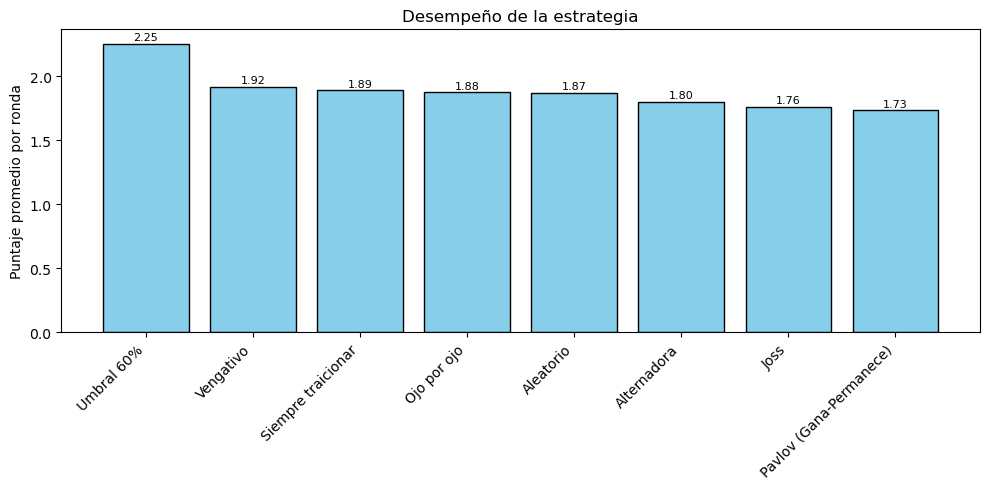

In [ ]:
#
# Cálculo de promedios para una estrategias vs todas las otras y ranking ===
promedio_por_estrategia = Resultados.mean(axis=1, skipna=True)
ranking = promedio_por_estrategia.sort_values(ascending=False)

# Mostramos el ranking como un DataDFrame
tabla = pd.DataFrame({
    "Estrategia": ranking.index,
    "Promedio final": ranking.values
})
print("===========================================")     
print("Promedios finales")
print("===========================================") 
print(tabla)


#Gráfica
print("\n==================================================================================================")     
print("Grafica de promedios")
print("==================================================================================================")  
plt.figure(figsize=(10, 5))
plt.bar(ranking.index, ranking.values, color='skyblue', edgecolor='black')
plt.ylabel("Puntaje promedio por ronda")
plt.title("Desempeño de la estrategia")
plt.xticks(rotation=45, ha='right')

# Etiquetas encima de las barras
for i, valor in enumerate(ranking.values):
    plt.text(i, valor + 0.01, f"{valor:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()